In [2]:
import image_generate
import pandas as pd 
import numpy as np
from PIL import Image
import torch
import torchvision
from sklearn.metrics import roc_auc_score

In [3]:
train_data = pd.read_csv("/content/drive/MyDrive/boostcamp/stage2_tabular/my_src_1/input/train.csv", parse_dates=["order_date"])
train_data["year_month"] = train_data["order_date"].dt.strftime('%Y-%m')

train_year = {"start": "2009-12", "end": "2010-12"}
valid_year = {"start": "2010-11", "end": "2011-11"}
test_year = {"start": "2010-12", "end": "2011-12"}

train, train_y, valid, valid_y, test, test_y = image_generate.generate_image(train_data, train_year, valid_year, test_year)

training dataset: 0it [00:00, ?it/s][Info] get_final_data........
training dataset: 12it [00:09,  1.24it/s]
validation dataset: 0it [00:00, ?it/s][Info] get_final_data........
validation dataset: 12it [00:10,  1.09it/s]
test dataset: 0it [00:00, ?it/s][Info] get_final_data........
test dataset: 12it [00:09,  1.27it/s]
test dataset: 100%|██████████| 5914/5914 [35:39<00:00,  2.76it/s]


In [4]:
train.to_csv("/content/drive/MyDrive/boostcamp/stage2_tabular/my_src/data/train_img.csv")
train_y.to_csv("/content/drive/MyDrive/boostcamp/stage2_tabular/my_src/data/train_label.csv")

valid.to_csv("/content/drive/MyDrive/boostcamp/stage2_tabular/my_src/data/valid_img.csv")
valid_y.to_csv("/content/drive/MyDrive/boostcamp/stage2_tabular/my_src/data/valid_label.csv")

test.to_csv("/content/drive/MyDrive/boostcamp/stage2_tabular/my_src/data/test_img.csv")
test_y.to_csv("/content/drive/MyDrive/boostcamp/stage2_tabular/my_src/data/test_label.csv")

In [5]:
from torch.utils.data import Dataset
from torchvision import transforms

In [6]:
class ImageDataset(Dataset):
    def __init__(self, data, label):
        super().__init__()
        self.image_list = data.drop("id", axis=1).to_numpy().reshape(-1, 28, 28)
        self.label_list = label.to_numpy()
        self.transform =transforms.Compose(
                                            [transforms.ToTensor()]
                                            )
    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, idx):
        label = self.label_list[idx]
        img_arr = self.image_list[idx]

        img = Image.fromarray(img_arr)
        img = self.transform(img)
        return img, label

In [7]:
 train_dataset = ImageDataset(train, train_y["label"])
 valid_dataset = ImageDataset(valid, valid_y["label"])
 test_dataset = ImageDataset(test, test_y["label"])

In [8]:
import matplotlib.pyplot as plt
img_0, label_0 = train_dataset[0]
img_1, label_1 = train_dataset[1]
img_0 = img_0.numpy().reshape(28, 28)
img_1 = img_1.numpy().reshape(28, 28)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:132: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


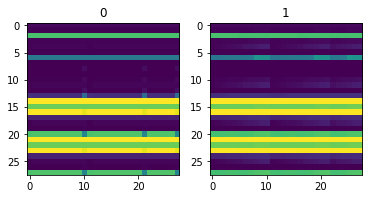

In [9]:
plt.subplot(1, 2, 1)
plt.imshow(img_0)
plt.title(label_0)

plt.subplot(1, 2, 2)
plt.imshow(img_1)
plt.title(label_1)

plt.show()


In [10]:
from torchvision.models import *
from sklearn.metrics import roc_auc_score
import torch.nn as nn 
import torch 
import torch.nn.functional as F 
from torch.utils.data import DataLoader
import torch.optim as optim

In [21]:
class mymodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet50(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet.fc = nn.Linear(in_features=2048, out_features=2, bias=True)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, input):
        x = self.resnet(input)
        x = self.softmax(x)
        return x

In [23]:
model = mymodel()
model = model.cuda()

myOptim = optim.Adam(model.parameters(), lr=1e-4)
loss = torch.nn.CrossEntropyLoss().cuda()

In [22]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)

In [14]:
len(train_dataset)

5914

In [24]:
for e in range(0, 50):
    model.train()
    for img, label in train_loader:
        img = img.cuda()
        label = label.cuda()

        myOptim.zero_grad()
        pred = model(img)
        cost = loss(pred, label)
        cost.backward()
        myOptim.step()
    if e % 5 == 0:
        with torch.no_grad():
    
            pred_list = []
            loss_tmp = 0
            for img, label in valid_loader:
                img = img.cuda()
                label = label.cuda()

                pred = model(img)
                cost = loss(pred, label)
                loss_tmp += cost 
                pred_list.extend(pred.cpu().numpy()[:, 1])
            
            score = roc_auc_score(valid_y, list(pred_list))
            print(f"{e}/50 auc --> {score}")


0/50 auc --> 0.659426079471247
5/50 auc --> 0.6012254125935014
10/50 auc --> 0.5599454492684793
15/50 auc --> 0.479309969525468
20/50 auc --> 0.5357727800424796
25/50 auc --> 0.5915726705452434
30/50 auc --> 0.576977381564887
35/50 auc --> 0.6055316717457554
40/50 auc --> 0.6094097538291051
45/50 auc --> 0.6216685795701904


In [25]:
class mymodel1(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet50(pretrained=False)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet.fc = nn.Linear(in_features=2048, out_features=2, bias=True)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, input):
        x = self.resnet(input)
        x = self.softmax(x)
        return x

In [26]:
model1 = mymodel1()
model1 = model1.cuda()

myOptim1 = optim.Adam(model1.parameters(), lr=1e-4)
loss1 = torch.nn.CrossEntropyLoss().cuda()

In [27]:
for e in range(0, 50):
    model1.train()
    for img, label in train_loader:
        img = img.cuda()
        label = label.cuda()

        myOptim1.zero_grad()
        pred = model1(img)
        cost = loss1(pred, label)
        cost.backward()
        myOptim1.step()
    if e % 5 == 0:
        with torch.no_grad():
            model1.eval()

            pred_list = []
            loss_tmp = 0
            for img, label in valid_loader:
                img = img.cuda()
                label = label.cuda()

                pred = model1(img)
                cost = loss1(pred, label)
                loss_tmp += cost 
                pred_list.extend(pred.cpu().numpy()[:, 1])
            
            score = roc_auc_score(valid_y, list(pred_list))
            print(f"{e}/50 auc --> {score}")


0/50 auc --> 0.5916825800451182
5/50 auc --> 0.6128563607340273
10/50 auc --> 0.6216826789884038
15/50 auc --> 0.5060958958325089
20/50 auc --> 0.5906212484004169
25/50 auc --> 0.579593112228071
30/50 auc --> 0.5969805807311248
35/50 auc --> 0.3806904757193177
40/50 auc --> 0.41173912613290065
45/50 auc --> 0.37890916676560993


In [30]:
class mymodel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet18(pretrained=False)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet.fc = nn.Linear(in_features=512, out_features=2, bias=True)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, input):
        x = self.resnet(input)
        x = self.softmax(x)
        return x

In [31]:
model2 = mymodel2()
model2 = model2.cuda()

myOptim2 = optim.Adam(model2.parameters(), lr=1e-4)
loss2 = torch.nn.CrossEntropyLoss().cuda()

In [32]:
for e in range(0, 50):
    model2.train()
    train_label_list = []
    train_pred_list
    for img, label in train_loader:
        img = img.cuda()
        label = label.cuda()

        myOptim2.zero_grad()
        pred = model2(img)
        cost = loss2(pred, label)
        cost.backward()
        myOptim2.step()
        train_pred_list.extend(pred.cpu().numpy()[:, 1])
        train_label_list.extend(label.cpu().numpy())
    if e % 5 == 0:
        with torch.no_grad():
            model2.eval()

            pred_list = []
            loss_tmp = 0
            for img, label in valid_loader:
                img = img.cuda()
                label = label.cuda()

                pred = model2(img)
                cost = loss2(pred, label)
                loss_tmp += cost 
                pred_list.extend(pred.cpu().numpy()[:, 1])
            
            score = roc_auc_score(valid_y, list(pred_list))
            train_score = roc_auc_score(list(train_label_list), list(train_pred_list))
            print(f"{e}/50 auc --> {score}")

0/50 auc --> 0.6664132894025145
5/50 auc --> 0.6557975818260973
10/50 auc --> 0.677651432698777
15/50 auc --> 0.6766833551008562
20/50 auc --> 0.6683626370364506
25/50 auc --> 0.6668554834368939
30/50 auc --> 0.6032368471392199
35/50 auc --> 0.6839847924169866
40/50 auc --> 0.4877644259310563
45/50 auc --> 0.551698608857403


In [33]:
class mymodel3(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet.fc = nn.Linear(in_features=512, out_features=2, bias=True)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, input):
        x = self.resnet(input)
        x = self.softmax(x)
        return x

In [34]:
model3 = mymodel3()
model3 = model3.cuda()

myOptim3 = optim.Adam(model3.parameters(), lr=1e-4)
loss3 = torch.nn.CrossEntropyLoss().cuda()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
for e in range(0, 50):
    model3.train()
    for img, label in train_loader:
        img = img.cuda()
        label = label.cuda()

        myOptim3.zero_grad()
        pred = model3(img)
        cost = loss3(pred, label)
        cost.backward()
        myOptim3.step()
    if e % 5 == 0:
        with torch.no_grad():
            model3.eval()

            pred_list = []
            loss_tmp = 0
            for img, label in valid_loader:
                img = img.cuda()
                label = label.cuda()

                pred = model3(img)
                cost = loss3(pred, label)
                loss_tmp += cost 
                pred_list.extend(pred.cpu().numpy()[:, 1])
            
            score = roc_auc_score(valid_y, list(pred_list))
            print(f"{e}/50 auc --> {score}")

In [28]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=73a74990eeba4182738d1f7d924aeaa1e2a4f344a6e2362d4c8ad7f4fa8a3d10
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [29]:
from efficientnet_pytorch import EfficientNet